In [94]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
# Importing the keras library and the TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Importing the necessary libraries to create/construct the deep neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense ,Dropout
from tensorflow.keras import initializers
import tensorflow as tf
import time
import warnings
warnings.filterwarnings('ignore')

In [95]:
# Importing the Beer Sales Dataset as pandas dataframe
dataset=pd.read_csv('data1.csv')

In [96]:
# Column renaming
dataset.rename(columns={'wqi':'water_quality_index'},inplace=True)
dataset.rename(columns={'dates':'DATE'},inplace=True)
dataset.head(5)

,DATE,water_quality_index
0,4/29/1986,62
1,5/19/1986,64
2,6/18/1986,67
3,7/24/1986,68
4,8/15/1986,68


In [97]:
# Convertir la colonne 'Date' en datetime
dataset['DATE'] = pd.to_datetime(dataset['DATE'])

# Remplacer toutes les valeurs de jour par 1
dataset['DATE'] = dataset['DATE'].apply(lambda x: x.replace(day=1))

In [98]:
# 'DATE' column is converted from 'object' data type to 'datetime' 
dataset['DATE'] = pd.to_datetime(dataset['DATE'])
# Feature Engineering is applied to extract the Months and Years from the 'DATE' column
dataset['Year'] = dataset['DATE'].apply(lambda date:date.year)
dataset['Month'] = dataset['DATE'].apply(lambda date:date.month)
dataset.head(2)

,DATE,water_quality_index,Year,Month
0,1986-04-01,62,1986,4
1,1986-05-01,64,1986,5


In [99]:
# 'DATE' column is set as dataset index
dataset=dataset.set_index(['DATE'])
dataset.head(2)

,water_quality_index,Year,Month
DATE,,,
1986-04-01,62,1986,4
1986-05-01,64,1986,5


In [100]:
# Mapping to rename the entries of the 'Month' column
num_to_name={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',
                                  6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
dataset['Month'] = dataset['Month'].map(num_to_name)
dataset.head(2)

,water_quality_index,Year,Month
DATE,,,
1986-04-01,62,1986,Apr
1986-05-01,64,1986,May


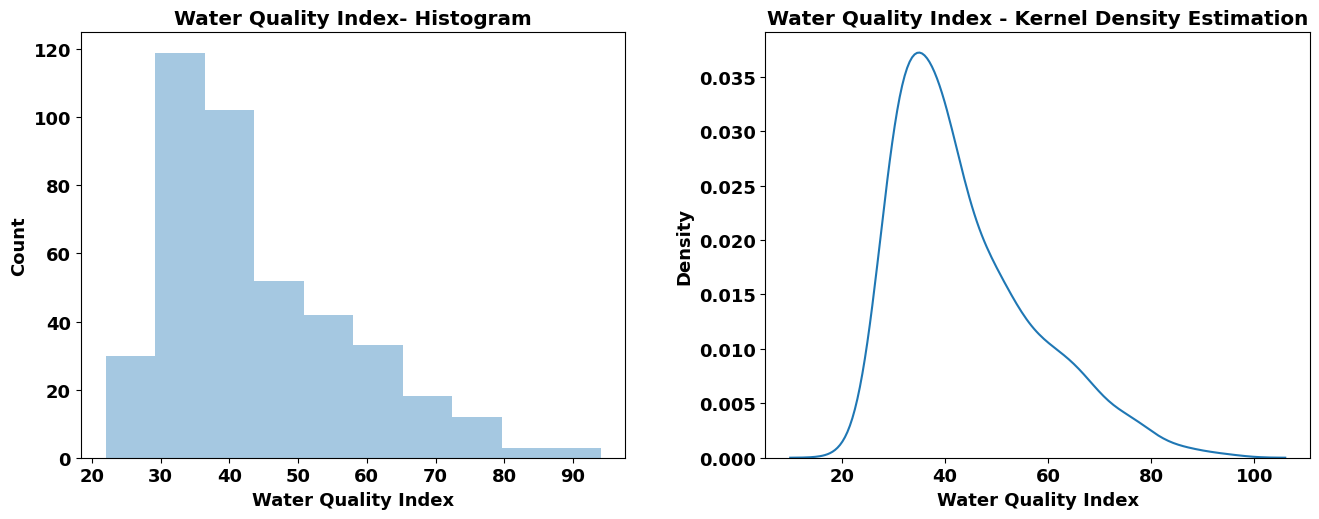

In [101]:
# Water quality index histogram and kernel density estimation plots
fig,axs=plt.subplots(1,2,figsize=(14,6))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=12

sns.distplot(dataset['water_quality_index'],kde=False,bins=10,ax=axs[0])
axs[0].set_title('Water Quality Index- Histogram',fontweight='bold')
axs[0].set_xlabel('Water Quality Index',fontweight='bold')
axs[0].set_ylabel('Count',fontweight='bold')

sns.distplot(dataset['water_quality_index'],kde=True,hist=False,ax=axs[1])
axs[1].set_title('Water Quality Index - Kernel Density Estimation',fontweight='bold')
axs[1].set_xlabel('Water Quality Index',fontweight='bold')
axs[1].set_ylabel('Density',fontweight='bold')

for ax in axs.flat:
    
    ax.figure.tight_layout(pad=3);

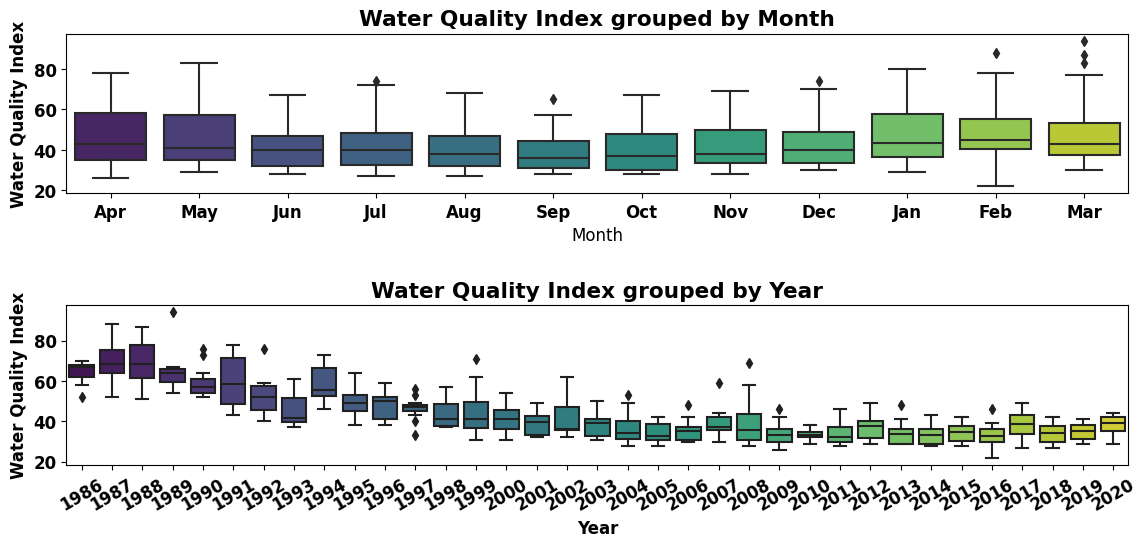

In [102]:
# Boxplots of Water quality index grouped by Month and Year. Based on the 'Months' boxplot, it can be observed that
fig,axs=plt.subplots(2,1,figsize=(12,6))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=13


sns.boxplot(x='Month',data=dataset,y='water_quality_index',palette='viridis',ax=axs[0])
axs[0].set_ylabel('Water Quality Index',fontweight='bold')
axs[0].set_title('Water Quality Index grouped by Month',fontweight='bold')
sns.boxplot(ax=axs[1],x='Year',data=dataset,y='water_quality_index',palette='viridis')
axs[1].set_xlabel('Year',fontweight='bold')
axs[1].set_ylabel('Water Quality Index',fontweight='bold')
axs[1].set_title('Water Quality Index grouped by Year',fontweight='bold')

plt.setp(axs[1].get_xticklabels(), rotation=30)
for ax in axs.flat:
   
    ax.figure.tight_layout(pad=2)

In [103]:
# Dropping the 'Year', 'Month' columns
data=dataset.drop(['Year','Month'],axis=1)
data.head()

,water_quality_index
DATE,
1986-04-01,62
1986-05-01,64
1986-06-01,67
1986-07-01,68
1986-08-01,68


Text(0.5, 1.0, 'Water Quality Index Time Series')

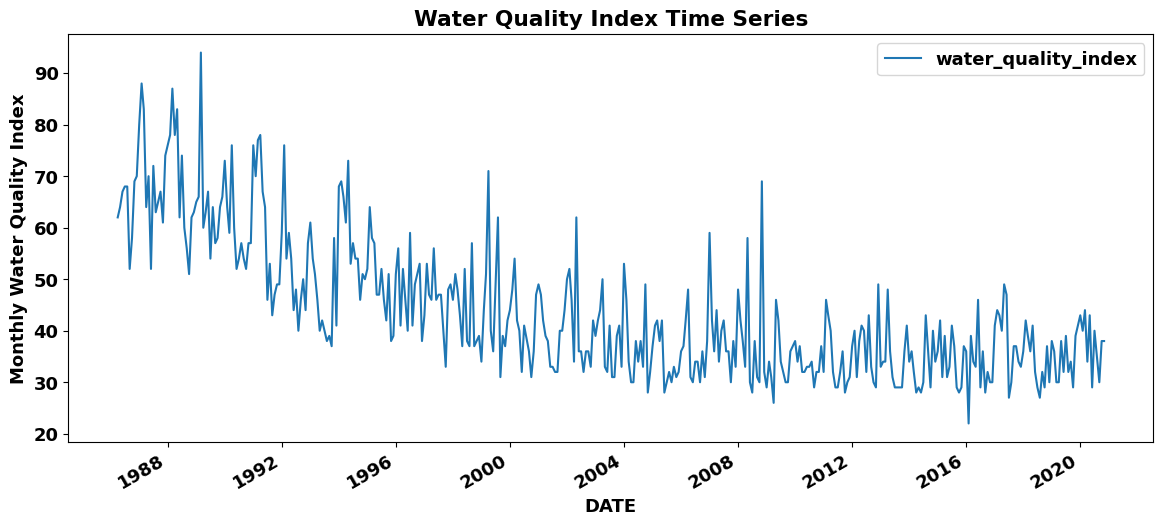

In [104]:
# Time Series Plot
data.plot(figsize=(14,6))
plt.xlabel('DATE',fontweight='bold')
plt.ylabel('Monthly Water Quality Index',fontweight='bold');
plt.title('Water Quality Index Time Series',fontweight='bold')

In [105]:
# Test size: 48 months
test_size = 24
# Dataset is split into training and test data
train = data.iloc[:len(dataset)- test_size]
test = data.iloc[-test_size:]

In [107]:
# Scaling the training and test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [108]:
# Training Batch length
length = 23
# No. of features
n_features=1
# Creating the time series generator
time_series_generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=64)

In [109]:
# First batch of the time_series_generator- training and test values
InpSeq,TargetVal=time_series_generator[0]
# At the first batch, the generator takes the first 29 samples to predict the next sample
print(InpSeq,TargetVal)

[[[0.55555556]
  [0.58333333]
  [0.625     ]
  ...
  [0.72222222]
  [0.75      ]
  [0.77777778]]

 [[0.58333333]
  [0.625     ]
  [0.63888889]
  ...
  [0.75      ]
  [0.77777778]
  [0.90277778]]

 [[0.625     ]
  [0.63888889]
  [0.63888889]
  ...
  [0.77777778]
  [0.90277778]
  [0.77777778]]

 ...

 [[0.625     ]
  [0.58333333]
  [0.33333333]
  ...
  [0.54166667]
  [0.44444444]
  [0.40277778]]

 [[0.58333333]
  [0.33333333]
  [0.43055556]
  ...
  [0.44444444]
  [0.40277778]
  [0.33333333]]

 [[0.33333333]
  [0.43055556]
  [0.29166667]
  ...
  [0.40277778]
  [0.33333333]
  [0.25      ]]] [[0.90277778]
 [0.77777778]
 [0.84722222]
 [0.55555556]
 [0.72222222]
 [0.52777778]
 [0.47222222]
 [0.40277778]
 [0.55555556]
 [0.56944444]
 [0.59722222]
 [0.61111111]
 [1.        ]
 [0.52777778]
 [0.56944444]
 [0.625     ]
 [0.44444444]
 [0.58333333]
 [0.48611111]
 [0.5       ]
 [0.58333333]
 [0.61111111]
 [0.70833333]
 [0.58333333]
 [0.51388889]
 [0.75      ]
 [0.52777778]
 [0.41666667]
 [0.44444444]


In [110]:
# The first batch samples are the first 29 values of the time series
scaled_train[:23]

array([[0.55555556],
       [0.58333333],
       [0.625     ],
       [0.63888889],
       [0.63888889],
       [0.41666667],
       [0.5       ],
       [0.65277778],
       [0.66666667],
       [0.80555556],
       [0.91666667],
       [0.84722222],
       [0.58333333],
       [0.66666667],
       [0.41666667],
       [0.69444444],
       [0.56944444],
       [0.59722222],
       [0.625     ],
       [0.54166667],
       [0.72222222],
       [0.75      ],
       [0.77777778]])

In [111]:
# The TargetVal of the time_series_generator first batch corresponds to the 48th [index 47] value of the scaled training data
print(TargetVal)
print(scaled_train[23])

[[0.90277778]
 [0.77777778]
 [0.84722222]
 [0.55555556]
 [0.72222222]
 [0.52777778]
 [0.47222222]
 [0.40277778]
 [0.55555556]
 [0.56944444]
 [0.59722222]
 [0.61111111]
 [1.        ]
 [0.52777778]
 [0.56944444]
 [0.625     ]
 [0.44444444]
 [0.58333333]
 [0.48611111]
 [0.5       ]
 [0.58333333]
 [0.61111111]
 [0.70833333]
 [0.58333333]
 [0.51388889]
 [0.75      ]
 [0.52777778]
 [0.41666667]
 [0.44444444]
 [0.48611111]
 [0.44444444]
 [0.41666667]
 [0.48611111]
 [0.48611111]
 [0.75      ]
 [0.66666667]
 [0.76388889]
 [0.77777778]
 [0.625     ]
 [0.58333333]
 [0.33333333]
 [0.43055556]
 [0.29166667]
 [0.34722222]
 [0.375     ]
 [0.375     ]
 [0.51388889]
 [0.75      ]
 [0.44444444]
 [0.51388889]
 [0.44444444]
 [0.30555556]
 [0.36111111]
 [0.25      ]
 [0.33333333]
 [0.38888889]
 [0.30555556]
 [0.48611111]
 [0.54166667]
 [0.44444444]
 [0.40277778]
 [0.33333333]
 [0.25      ]
 [0.27777778]]
[0.90277778]


**CNN Training**

In [164]:
# Use of random seed to get the same results at every run
tf.random.set_seed(0)
np.random.seed(0)

# Use of the he_uniform initializer to set the initial random weights of the model layers. 
initializer = tf.keras.initializers.he_uniform(seed=0)

# Initially, the network model is defined 
model = Sequential()

# CNN
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(length, n_features),kernel_initializer=initializer))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
# The output layer consists of 1 neuron with a 'linear' activation fuction 
model.add(Dense(1,activation='linear',kernel_initializer=initializer))
# The model is compiled using MSE as  loss function and Adam as optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')

# A validation generator is constructed in a similar way to the previous time_series_generator with the only difference being
# the use of scaled_test values for validation purposes
time_series_val_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=128)
# Début du chrono
start_time_forcasting_cnn = time.time()
# The model is trained for 1000 epochs. At each epoch both training and validation losses can be observed
model.fit_generator(time_series_generator,epochs=1000,shuffle=False,
                    validation_data=time_series_val_generator) 
# Fin du chrono
end_time_forcasting_cnn = time.time()

Epoch 1/1000
6/6 [==============================] - 2s 64ms/step - loss: 0.0964 - val_loss: 0.0040
Epoch 2/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0186 - val_loss: 8.5426e-04
Epoch 3/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0131 - val_loss: 0.0023
Epoch 4/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0123 - val_loss: 9.0820e-04
Epoch 5/1000
6/6 [==============================] - 0s 25ms/step - loss: 0.0115 - val_loss: 0.0037
Epoch 6/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0116 - val_loss: 6.5334e-04
Epoch 7/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0121 - val_loss: 0.0071
Epoch 8/1000
6/6 [==============================] - 0s 22ms/step - loss: 0.0132 - val_loss: 1.8706e-05
Epoch 9/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0154 - val_loss: 0.0124
Epoch 10/1000
6/6 [==============================] - 0s 22ms/step - loss: 0.0198 - val_loss: 

In [165]:
# Calcul de la durée d'entraînement en secondes
training_time_forcasting_cnn = end_time_forcasting_cnn - start_time_forcasting_cnn
# Affichage de la durée d'entraînement
print("Le temps d'entraînement est de", training_time_forcasting_cnn, "secondes")

Le temps d'entraînement est de 257.1605455875397 secondes


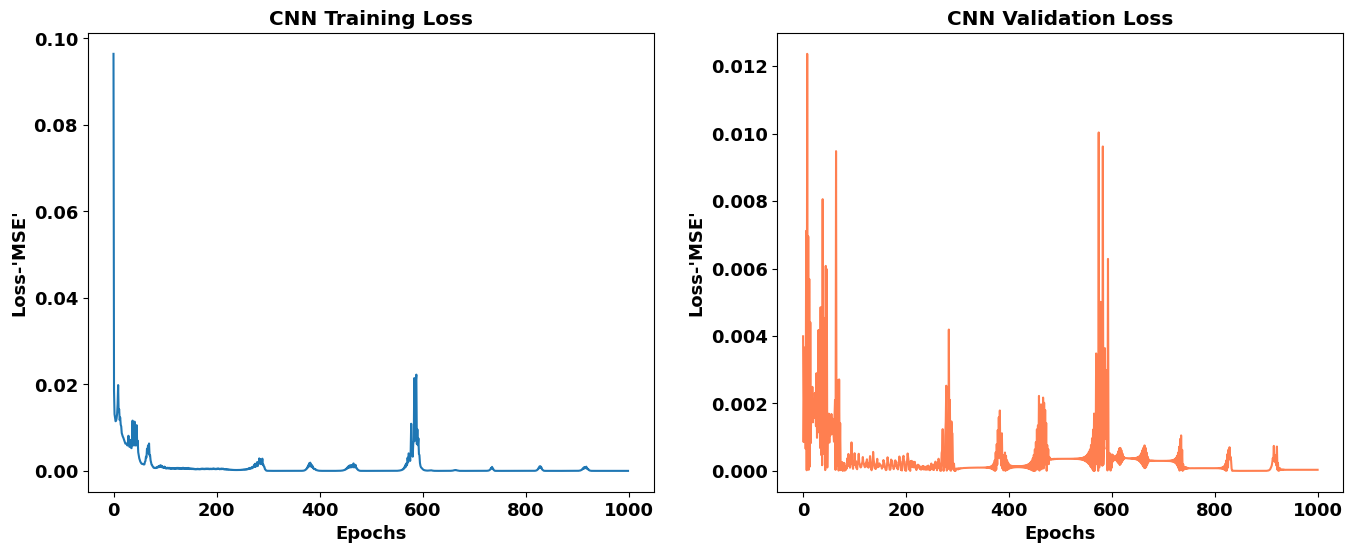

In [166]:
# Training and validation loss plots
fig,axs=plt.subplots(1,2,figsize=(14,6))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=12
train_loss = pd.DataFrame(model.history.history)
train_loss.loss.plot(ax=axs[0])
axs[0].set_title('CNN Training Loss',fontweight='bold')
train_loss.val_loss.plot(ax=axs[1],color='coral')
axs[1].set_title('CNN Validation Loss',fontweight='bold')
for ax in axs.flat:
    ax.set_xlabel('Epochs',fontweight='bold')
    ax.set_ylabel("Loss-'MSE'",fontweight='bold')

   
    ax.figure.tight_layout(pad=2)

**CNN Predictions on the Training Set**

In [167]:
# Determining all CNN outputs
training_outputs = []
batch = scaled_train[:length].reshape((1, length, n_features))

for i in range(len(scaled_train[length:])):
    train_out = model.predict(batch)[0]
    training_outputs.append(train_out) 
    batch = np.append(batch[:,1:,:],[[scaled_train[length:][i]]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [168]:
#Inverse transforming the expected values
actual_train=scaled_train[length:]
actual_train=scaler.inverse_transform(actual_train)

In [169]:
# Inverse transforming the CNN predictions on the training set
train_predictions=scaler.inverse_transform(training_outputs)

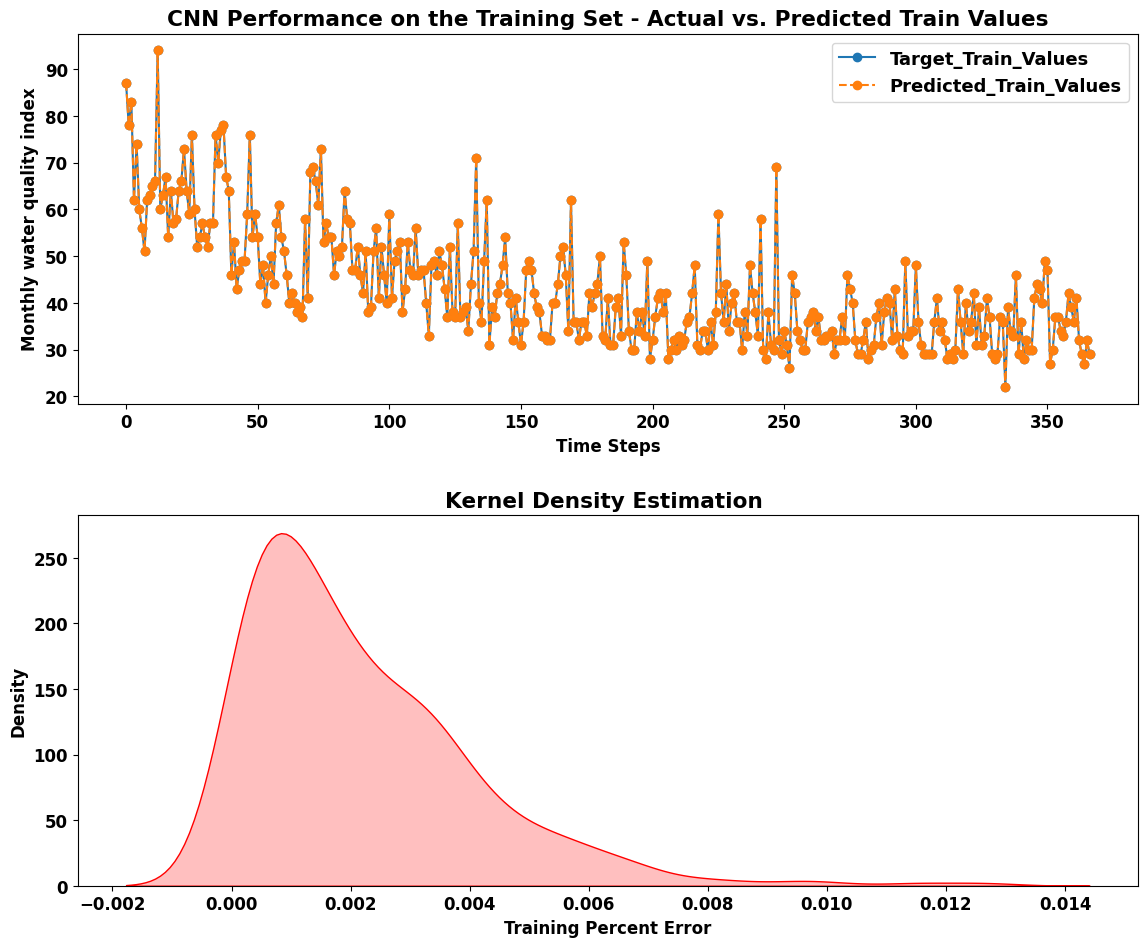

In [170]:
#'CNN Performance on the training set - Actual vs. Predicted Values'
fig,axs=plt.subplots(2,1,figsize=(12,10))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=13

axs[0].plot(actual_train,marker='o',linestyle='-',label='Target_Train_Values')

axs[0].plot(train_predictions,marker='o',linestyle='dashed',label='Predicted_Train_Values')
axs[0].set_title('CNN Performance on the Training Set - Actual vs. Predicted Train Values',fontweight='bold')

axs[0].legend()
axs[0].set_xlabel('Time Steps',fontweight='bold')
axs[0].set_ylabel('Monthly water quality index',fontweight='bold');

# Training percent error distribution plot
train_err=abs((actual_train-train_predictions)/actual_train)*100
train_err=pd.DataFrame(train_err,columns=['Training Error'])

sns.kdeplot(train_err['Training Error'],shade=True,color='r',kernel='gau',ax=axs[1])
axs[1].set_xlabel('Training Percent Error',fontweight='bold')
axs[1].set_ylabel('Density',fontweight='bold');
axs[1].set_title('Kernel Density Estimation ',fontweight='bold')
for ax in axs.flat:
    ax.figure.tight_layout(pad=2);

In [158]:
# Summary statistics of training percent error
train_err.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Training Error,367.0,0.000004,0.000004,0.0,0.000001,0.000003,0.000005,0.000023


**CNN Predictions on the Test Set**

In [171]:
# Determining all CNN outputs 
test_outputs = []
batch = scaled_train[-length:].reshape((1, length, n_features))

for i in range(len(test)):
    test_out = model.predict(batch)[0]
    test_outputs.append(test_out) 
    batch = np.append(batch[:,1:,:],[[test_out]],axis=1)

1/1 [==============================] - 0s 39ms/step


In [172]:
# Inverse transforming the CNN predicitons
cnn_predictions = scaler.inverse_transform(test_outputs)

In [173]:
# A new test feature is created to comprise the CNN test predictions
test['CNN Predictions'] = cnn_predictions.round(2)

In [174]:
# test(Actual) and CNN Predictions
test

,water_quality_index,CNN Predictions
DATE,,
2018-11-01,37,37.86
2018-12-01,30,37.63
2019-01-01,38,40.08
2019-02-01,36,49.01
2019-03-01,30,45.63
2019-04-01,30,36.10
2019-05-01,38,34.39
2019-06-01,32,43.08
2019-07-01,39,36.21


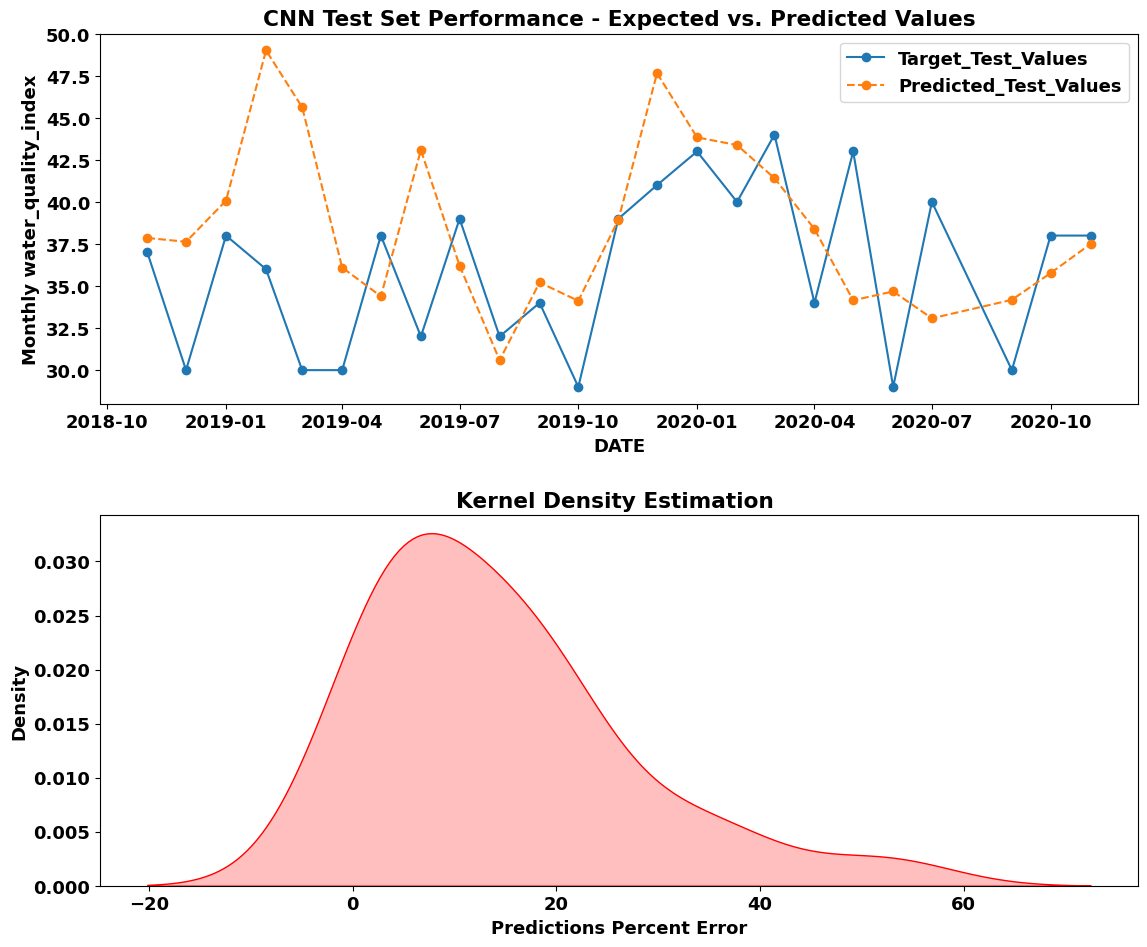

In [175]:
# Plot of the Test vs. Predicted values for a prediction horizon of 48 months 
fig,axs=plt.subplots(2,1,figsize=(12,10))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=13

axs[0].plot(test['water_quality_index'],marker='o',linestyle='-',label='Target_Test_Values')

axs[0].plot(test['CNN Predictions'],marker='o',linestyle='dashed',label='Predicted_Test_Values')
axs[0].set_title('CNN Test Set Performance - Expected vs. Predicted Values',fontweight='bold')

axs[0].legend()
axs[0].set_xlabel('DATE',fontweight='bold')
axs[0].set_ylabel('Monthly water_quality_index',fontweight='bold');

# CNN Predictions percent Error distribution plot
test_err=abs((test['water_quality_index']-test['CNN Predictions'])/test['water_quality_index'])*100
test_err=pd.DataFrame(test_err,columns=['Test Set Error'])

sns.kdeplot(test_err['Test Set Error'],shade=True,color='r',kernel='gau',ax=axs[1])
axs[1].set_xlabel('Predictions Percent Error',fontweight='bold')
axs[1].set_ylabel('Density',fontweight='bold');
axs[1].set_title('Kernel Density Estimation ',fontweight='bold')
for ax in axs.flat:
    ax.figure.tight_layout(pad=2);

In [176]:
model.save('forcasting_wqi_hong_kong_using_cnn_v6.h5')

**Monthly WQI future forecast using CNN**

In [177]:
# A new scaler is being initialized
data_scaler=MinMaxScaler()
# fit_transform function applied to all dataset's entries
scaled_set=data_scaler.fit_transform(data)
# A new TimeseriesGenerator is created to include the new scaled values, (batch_size = 1 , length=12)
length=23
data_generator=TimeseriesGenerator(scaled_set,scaled_set,length=length,batch_size=1)

In [178]:
# Determining all CNN predictions on the Training Set 
full_training_outputs = []
batch = scaled_set[:length].reshape((1, length, n_features))

for i in range(len(scaled_set[length:])):
    full_train_out = model.predict(batch)[0]
    full_training_outputs.append(full_train_out) 
    batch = np.append(batch[:,1:,:],[[scaled_set[length:][i]]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [182]:
# Inverse transforming the actual training values
f_train=scaled_set[length:]
f_train=scaler.inverse_transform(f_train)

In [180]:
# Inverse transforming the CNN predictions on the training set
f_train_predictions=scaler.inverse_transform(full_training_outputs)

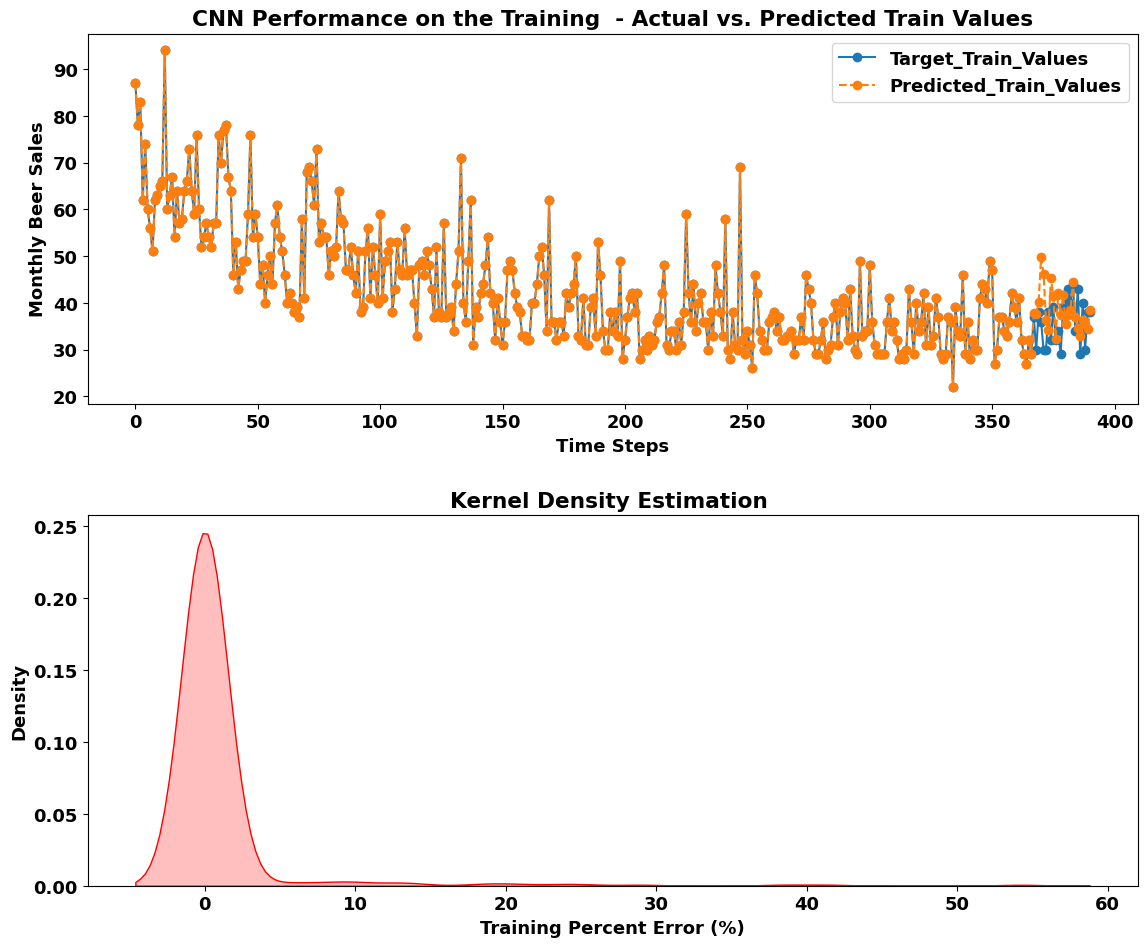

In [202]:
#'CNN Training Performance - Actual vs. Predicted Training Values'
fig,axs=plt.subplots(2,1,figsize=(12,10))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=13

axs[0].plot(f_train,marker='o',linestyle='-',label='Target_Train_Values')

axs[0].plot(f_train_predictions,marker='o',linestyle='dashed',label='Predicted_Train_Values')
axs[0].set_title('CNN Performance on the Training  - Actual vs. Predicted Train Values',fontweight='bold')

axs[0].legend()
axs[0].set_xlabel('Time Steps',fontweight='bold')
axs[0].set_ylabel('Monthly Beer Sales',fontweight='bold');

# Training Percent Error distribution plot
f_train_err=abs((f_train-f_train_predictions)/f_train)*100
f_train_err=pd.DataFrame(f_train_err,columns=['Training Error'])

sns.kdeplot(f_train_err['Training Error'],shade=True,color='r',kernel='gau',ax=axs[1])
axs[1].set_xlabel('Training Percent Error (%)',fontweight='bold')
axs[1].set_ylabel('Density',fontweight='bold');
axs[1].set_title('Kernel Density Estimation ',fontweight='bold')
for ax in axs.flat:
    ax.figure.tight_layout(pad=2);

In [184]:
# Determining all LSTM outputs 
test_outputs = []
batch = scaled_train[-length:].reshape((1, length, n_features))

for i in range(len(test)):
    test_out = model.predict(batch)[0]
    test_outputs.append(test_out) 
    batch = np.append(batch[:,1:,:],[[test_out]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [185]:
# Inverse transforming the LSTM predicitons
cnn_predictions = scaler.inverse_transform(test_outputs)

In [186]:
# A new test feature is created to comprise the LSTM test predictions
test['CNN Predictions'] = cnn_predictions.round(2)

In [187]:
# test(Actual) and LSTM Predictions
test

,water_quality_index,CNN Predictions
DATE,,
2018-11-01,37,37.86
2018-12-01,30,37.63
2019-01-01,38,40.08
2019-02-01,36,49.01
2019-03-01,30,45.63
2019-04-01,30,36.10
2019-05-01,38,34.39
2019-06-01,32,43.08
2019-07-01,39,36.21


In [191]:
# Creating an index for the LSTM predictions on the Training Set
train_index=pd.date_range(start='1986-04-01',periods=367,freq='M')

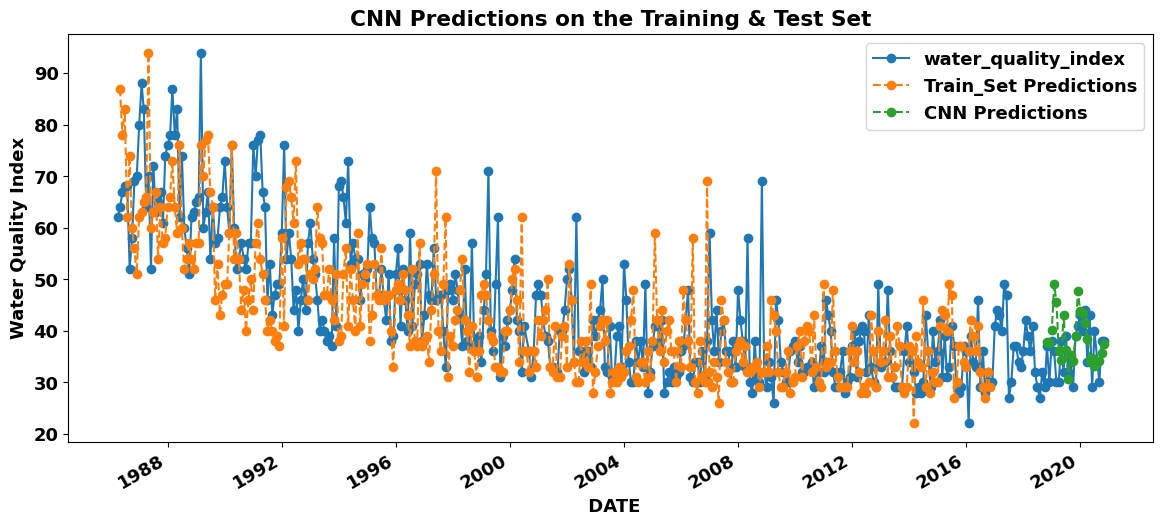

In [194]:
# Converting the train_predictions from np.ndarray to pandas dataframe
train_df=pd.DataFrame(data=train_predictions,index=train_index,columns=['Train_Set Predictions'])

# Plot comprising the original time series and the LSTM predictions on the Training and Test Set
ax=data.plot(figsize=(14,6),marker='o',linestyle='-')

train_df.plot(ax=ax,marker='o',linestyle='--',legend=True)
test['CNN Predictions'].plot(ax=ax,legend=True,marker='o',linestyle='dashed')
plt.title('CNN Predictions on the Training & Test Set',fontweight='bold')
plt.ylabel('Water Quality Index',fontweight='bold')
plt.xlabel(' DATE',fontweight='bold');

In [195]:
# Creating an index for the LSTM predictions on the Training Set
f_train_index=pd.date_range(start='1986-04-29',periods=391,freq='M')

In [196]:
# Converting the LSTM predictions from np.ndarray to pandas dataframe
f_train_df=pd.DataFrame(data=f_train_predictions,index=f_train_index,columns=['Predicted_Train'])

In [197]:
# Obtaining the CNN forecasted values 
cnn_outputs=[]
batch = scaled_set[-length:].reshape((1, length, n_features))

for i in range(length):
    cnn_out = model.predict(batch)[0]
    cnn_outputs.append(cnn_out) 
    batch = np.append(batch[:,1:,:],[[cnn_out]],axis=1)

1/1 [==============================] - 0s 26ms/step


In [198]:
# Inverse transforming the CNN forecasts
cnn_outputs=data_scaler.inverse_transform(cnn_outputs)
cnn_outputs

array([[36.14023471],
       [42.77522802],
       [48.04911613],
       [45.35314631],
       [46.00061226],
       [49.57571793],
       [39.62102318],
       [30.59853286],
       [35.75301921],
       [36.05638349],
       [35.50801015],
       [35.60782909],
       [38.54686177],
       [43.17376137],
       [48.61177492],
       [47.56831837],
       [49.12860656],
       [41.46559763],
       [40.44702554],
       [33.36107993],
       [31.8807838 ],
       [31.99425411],
       [35.41298914]])

In [199]:
# Creating an index for the CNN forecasts
cnn_forecast_index=pd.date_range(start='2020-12-01',periods=23,freq='M')

In [200]:
# Converting the cnn_outputs from np.ndarray to pandas dataframe
cnn_forecast_df=pd.DataFrame(data=cnn_outputs,index=cnn_forecast_index,columns=['CNN Forecasts'])
cnn_forecast_df

,CNN Forecasts
2020-12-31,36.140235
2021-01-31,42.775228
2021-02-28,48.049116
2021-03-31,45.353146
2021-04-30,46.000612
2021-05-31,49.575718
2021-06-30,39.621023
2021-07-31,30.598533
2021-08-31,35.753019
2021-09-30,36.056383


Text(0.5, 0, ' DATE')

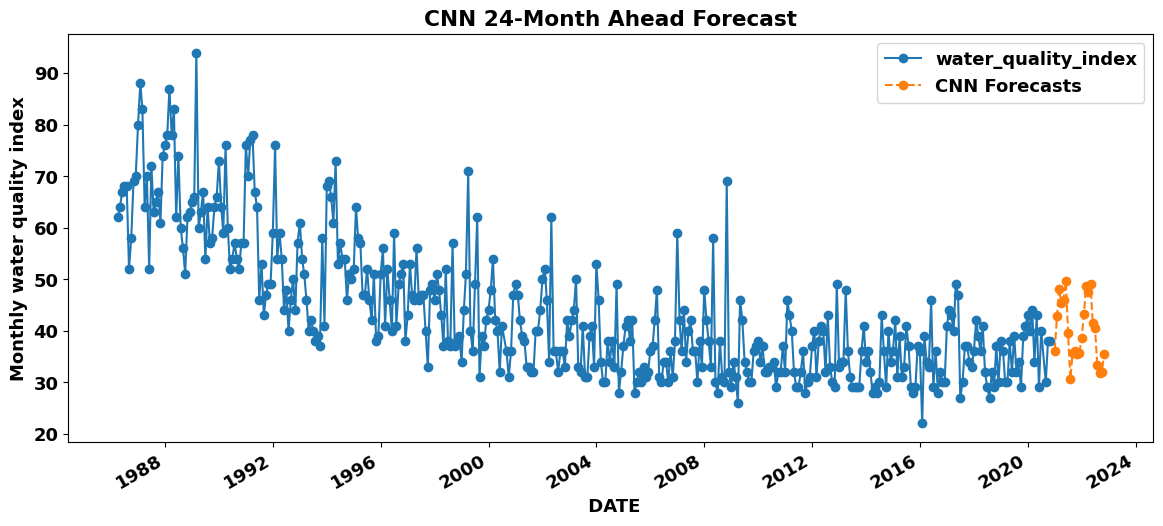

In [201]:
# Plot comprising the original time series,and the 48-month CNN forecasts
ax=data.plot(figsize=(14,6),marker='o',linestyle='-')
cnn_forecast_df.plot(ax=ax,marker='o',linestyle='--')
plt.title('CNN 24-Month Ahead Forecast',fontweight='bold')
plt.ylabel('Monthly water quality index',fontweight='bold')
plt.xlabel(' DATE',fontweight='bold')